In [ ]:
#@title Copyright 2020 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Detecting Changes in Sentinel-1 Imagery (Part 1)
Author: mortcanty

In this tutorial we will analyze synthetic aperture radar (SAR) imagery  in order to detect statistically significant changes on the Earth surface. As the adverb "statistically" hints, we will need a basic understanding of the statistical properties of SAR imagery in order to proceed, and the adjective "significant" implies that we  learn the fundamentals of hypothesis testing. In particular we will be concerned with time series of the dual polarimetric intensity Sentinel-1 SAR images in the GEE archive. The tutorial is in four parts:

- 1. Single and multi-look image statistics
- 2. Hypothesis testing 
- 3. Multitemporal change detection
- 4. Applications

Much of the material is based on Chapters 5 and 9 of my text [Image Analysis, Classification and Change Detection in Remote Sensing](https://www.taylorfrancis.com/books/9780429464348), and the most relevant original publications are [Conradsen et al. (2003)](https://ieeexplore.ieee.org/document/1183688),  [Conradsen et al. (2016)](https://ieeexplore.ieee.org/document/7398022) and  [Canty et al. (2020)](https://www.mdpi.com/2072-4292/12/1/46).


## Context

The [Sentinel-1 missions of the ESA]( https://sentinel.esa.int/web/sentinel/missions/sentinel-1) provide a fantastic source of weather-independent, day-or-night Earth observation data with repeat times of the order of 6 days. The Google Earth Engine team monitor and ingest the imagery data almost as fast as they are produced, thus removing the burden from the user of searching, downloading, pre-processing and georeferencing. The JavaScript and Python API's to GEE can then be easily programmed to analyze time series of Sentinel-1 acquisitions virtually anywhere on the globe. Detected changes, both short- and long-term, can be related to landscape dynamics and human activity.



## Prerequisites

A basic knowledge of the Sentinel-1 SAR platform is assumed on the part of the reader,  at the level of the [ESA User Guides](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar). The reader should also be familiar with ordinary Python syntax and also with the GEE API (Python or JavaScript, it doesn't matter as they are almost identical).
We will take a relaxed view of statistical formalism, without clearly distinguishing random variables from their realizations (measurements). We assume that the reader has, at least, an intuitive understanding of the mean and variance of independent measurements $x_i$ of a quantity $x$,

$$
{\rm mean}(x) = {1\over n}\sum_{i=1}^n x_i
$$
$$
{\rm var}(x) = {1\over n}\sum_{i=1}^n(x_i-{\rm mean}(x))^2
$$

and that the measurements can be described by a probability density function
$p(x)$ with

$$
\quad {\rm mean}(x) = \int_{-\infty}^\infty x p(x)dx,\quad {\rm var}(x) = \int_{-\infty}^\infty (x-{\rm mean}(x))^2 p(x)dx
$$
and
$$
\quad \int_{-\infty}^\infty p(x)dx = 1.
$$

More statistics will be introduced as needed.
A highly recommended reference is [Freund's Mathematical Statistics](https://www.amazon.de/John-Freunds-Mathematical-Statistics/dp/013123613X/ref=sr_1_8?__mk_de_DE=%C3%85M%C3%85%C5%BD%C3%95%C3%91&dchild=1&keywords=freund+mathematical+statistics&qid=1597837319&sr=8-8).


## Part 1. Single and multi-look image statistics



### Run me first

Run the following cell to initialize the API. The output will contain instructions on how to grant this notebook access to Earth Engine using your account.

In [1]:
import ee
 
# Trigger the authentication flow.
#ee.Authenticate()
 
# Initialize the library.
ee.Initialize()

### Datasets and Python modules
Two [datasets](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD) will be used in the tutorial:

- COPERNICUS/S1_GRD_FLOAT
    - Sentinel-1 ground range detected images
- COPERNICUS/S1_GRD  
    - Sentinel-1 ground range detected images converted to decibels

The following cell imports some python modules which we will be using as we go along,  and also enables inline graphics.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
%matplotlib inline

And in order to make use of interactive maps, we import the _folium_ package:

In [3]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

### A Sentinel-1 image

Let's start work by grabbing a spatial subset of a Sentinel-1 image from the archive. We'll define an region of interest (AOI) as a random polygon over Paramaribo city in Suriname. A convenient way to do this is with the [geojson.io](http://geojson.io/#map=2/20.0/0.0) website, from which we can cut and paste the corresponding GeoJSON object description.

In [5]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -55.21848678588867,
              5.872867803938939
            ],
            [
              -55.256595611572266,
              5.836153112227562
            ],
            [
              -55.243377685546875,
              5.7832114200335125
            ],
            [
              -55.18226623535156,
              5.760837793657766
            ],
            [
              -55.10570526123047,
              5.794312509472417
            ],
            [
              -55.11669158935547,
              5.873892365348979
            ],
            [
              -55.174198150634766,
              5.882771818579644
            ],
            [
              -55.21848678588867,
              5.872867803938939
            ]
          ]
        ]
      }
    }
  ]
}

Note that the last and first corners are identical, indicating closure of the polygon. We have to bore down into the GeoJSON structure to get the geometry coordinates, then create an _ee.Geometry()_ object:

In [6]:
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)

Next, we filter the S1 archive to get an image over the _aoi_ acquired sometime in August, 2020. Any old image will do fine, so we won't bother to specify the orbit number or whether we want the ASCENDING or DESCENDING node. If we don't specify the instrument mode or resolution, we get _IW_ (interferometric wide swath) mode and $10\times 10\ m^2$ pixels by default. For convenience we grab both decibel and float versions:

In [7]:
ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD') 
                       .filterBounds(aoi) 
                       .filterDate(ee.Date('2021-03-01'), ee.Date('2021-03-10')) 
                       .first() 
                       .clip(aoi))
ffa_fl = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') 
                       .filterBounds(aoi) 
                       .filterDate(ee.Date('2021-04-25'), ee.Date('2021-05-01')) 
                       .first() 
                       .clip(aoi))

Notice that we have clipped the images to our _aoi_ so as not to work with the entire swath. To confirm that we have an image, we list its band names, fetching the result from the GEE servers with the _getInfo()_ class method:

In [8]:
ffa_db.bandNames().getInfo()

['VV', 'VH', 'angle']

and display the VV band of the decibel version using the _getThumbURL()_ method and IPython's _display_ module. The float intensities $I$ are generally between 0 and 1, so we stretch the decibel image $10\log_{10}(I)$ from $-20$ to $0$:

In [9]:
url = ffa_db.select('VV').getThumbURL({'min': -20, 'max': 0})
disp.Image(url=url, width=800)

This is fine, but a little boring. We can use _folium_ to project onto a map for geographical context. The _folium_ _Map()_ constructor wants its _location_ keyword in long-lat rather than lat-long, so we do a list reverse in the first line:

In [10]:
location = aoi.centroid().coordinates().getInfo()[::-1]

# Make an RGB color composite image (VV,VH,VV/VH).
rgb = ee.Image.rgb(ffa_db.select('VV'),
                   ffa_db.select('VH'),
                   ffa_db.select('VV').divide(ffa_db.select('VH')))

# Create the map object.
m = folium.Map(location=location, zoom_start=12)

# Add the S1 rgb composite to the map object.
m.add_ee_layer(rgb, {'min': [-20, -20, 0], 'max': [0, 0, 2]}, 'FFA')

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)

### Pixel distributions

In order to examine the statistics of the pixels in this image empirically, we'll need samples from a featureless (textureless) spatial subset. Here is a polygon covering the triangular wooded area just east of the north-south runway:

In [11]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -55.21848678588867,
              5.872867803938939
            ],
            [
              -55.256595611572266,
              5.836153112227562
            ],
            [
              -55.243377685546875,
              5.7832114200335125
            ],
            [
              -55.18226623535156,
              5.760837793657766
            ],
            [
              -55.10570526123047,
              5.794312509472417
            ],
            [
              -55.11669158935547,
              5.873892365348979
            ],
            [
              -55.174198150634766,
              5.882771818579644
            ],
            [
              -55.21848678588867,
              5.872867803938939
            ]
          ]
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -55.162739753723145,
              5.819481285890801
            ],
            [
              -55.16340494155884,
              5.817560044911445
            ],
            [
              -55.16525030136108,
              5.815019727317559
            ],
            [
              -55.15917778015136,
              5.813077123770661
            ],
            [
              -55.15728950500488,
              5.8160230474019
            ],
            [
              -55.15432834625244,
              5.817197143100488
            ],
            [
              -55.14898538589477,
              5.817303878951558
            ],
            [
              -55.14591693878174,
              5.817645433538808
            ],
            [
              -55.146324634552,
              5.82622692442722
            ],
            [
              -55.148813724517815,
              5.824625909953514
            ],
            [
              -55.150787830352776,
              5.8247112975073385
            ],
            [
              -55.15658140182495,
              5.823601258295259
            ],
            [
              -55.15984296798706,
              5.821253091196477
            ],
            [
              -55.162010192871094,
              5.820143045152388
            ],
            [
              -55.162739753723145,
              5.819481285890801
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi_sub = ee.Geometry.Polygon(coords)

Using standard reducers from the GEE library we can easily calculate a histogram and estimate the first two moments (mean and variance) of the pixels in the polygon _aoi\_sub_ , again retrieving the results from the servers with _getInfo()_ .

In [12]:
hist = ffa_fl.select('VV').reduceRegion(
    ee.Reducer.fixedHistogram(0, 0.5, 500),aoi_sub).get('VV').getInfo()
mean = ffa_fl.select('VV').reduceRegion(
    ee.Reducer.mean(), aoi_sub).get('VV').getInfo()
variance = ffa_fl.select('VV').reduceRegion(
    ee.Reducer.variance(), aoi_sub).get('VV').getInfo()

Here is a plot of the (normalized) histogram using _numpy_ and _matplotlib_ :

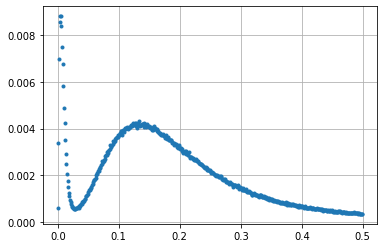

In [13]:
a = np.array(hist)
x = a[:, 0]                 # array of bucket edge positions
y = a[:, 1]/np.sum(a[:, 1]) # normalized array of bucket contents
plt.grid()
plt.plot(x, y, '.')
plt.show()

The above histogram is in fact a _gamma probability density distribution_ 

$$
p_{\gamma;\alpha,\beta}(x) = {1\over \beta^\alpha\Gamma(\alpha)}x^{\alpha-1}e^{-x/\beta},\quad {\rm mean}(x) = \alpha\beta,\quad {\rm var}(x) = \alpha\beta^2 \tag{1.1}
$$
where
$$
\Gamma(\alpha) = \int_0^\infty z^{\alpha-1}e^{-z} dz.
$$

The parameters are in this case $\alpha = 5$ and $\beta = {\mu}/\alpha$, where $\mu$ is the estimated mean value we just determined with _ee.Reducer.mean()_. 
This can easily be verified by plotting the gamma distribution _gamma.pdf()_ and overlaying it onto the histogram. Since the bucket widths are 0.001, we have to divide the plot by 1000.

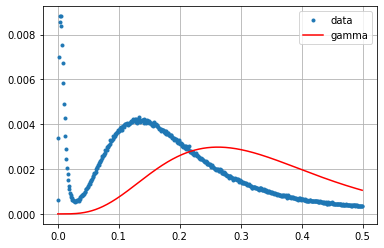

In [14]:
alpha = 5
beta = mean/alpha
plt.grid()
plt.plot(x, y, '.', label='data')
plt.plot(x, gamma.pdf(x, alpha, 0, beta)/1000, '-r', label='gamma')
plt.legend()
plt.show()

In order to understand just why this is the case, let's take a step back and consider how the pixels were generated.


### Single look complex (SLC) SAR measurements
The Sentinel-1 platform is a dual polarimetric synthetic aperture radar system, emitting radar microwaves in the C-band with one polarization (vertical in most cases) and recording both vertical and horizontal reflected polarizations. This is represented mathematically as

$$
\pmatrix{E_v^b\cr E_h^b} = {e^{-{\bf i}rk}\over r}\pmatrix{S_{vv} & S_{vh}\cr S_{hv} & S_{hh}}\pmatrix{E_v^i\cr 0}. \tag{1.2}
$$

The incident, vertically polarized radar signal $\pmatrix{E_v^i\cr 0}$ is transformed by a complex _scattering matrix_ $\pmatrix{S_{vv} & S_{vh}\cr S_{hv} & S_{hh}}$ into the backscattered signal $\pmatrix{E_v^b\cr E_h^b}$ having both vertical and horizontal polarization components. The exponent term accounts for the phase shift due to the return distance $r$ from target to sensor, where $k$ is the wave number, $k=2\pi/\lambda$. From measurement of the backscattered radiation at the sensor, two of the four complex scattering matrix elements can be derived and processed into two-dimensional (slant range $\times$ azimuth) arrays, comprising the so-called _single look complex_ image. Written as a complex vector, the two derived elements are
 
$$
S = \pmatrix{S_{vv}\cr S_{vh}}.          \tag{1.3}
$$

We write the complex transpose of the vector $S$ as $S^\dagger = (S_{vv}^*\ S_{vh}^*)$, where the $^*$ denotes complex conjugation. The inner product of $S$ with itself is the total power (also referred to as the _span_ image)

$$
P = S^\dagger S = (S_{vv}^*\ S_{vh}^*)\pmatrix{S_{vv}\cr S_{vh}} = |S_{vv}|^2 + |S_{vh}|^2 \tag{1.4}
$$

and the outer product is the (dual pol) _covariance matrix image_

$$
C2 = SS^\dagger = \pmatrix{S_{vv}\cr S_{vh}}(S_{vv}^*\ S_{vh}^*) = \pmatrix{|S_{vv}|^2 & S_{vv}^*S_{vh} \cr S_{vh}^*S_{vv} & |S_{vh}|^2}. \tag{1.5}
$$

The diagonal elements are real numbers, the off-diagonal elements are complex conjugates of each other and contain the relative phases of the $S_{vv}$ and $S_{vh}$ components. The off-diagonal elements are not available for S1 archived imagery in GEE, so that if we nevertheless choose to represent the data in covariance matrix form, the matrix is diagonal: 

$$
C2 = \pmatrix{|S_{vv}|^2 & 0 \cr 0 & |S_{vh}|^2}, \tag{1.6a}
$$

In terms of radar scattering cross sections (sigma nought),

$$
C2 = {1\over 4\pi}\pmatrix{\sigma^o_{vv}  & 0 \cr 0 & \sigma^o_{vh}}. \tag{1.6b}
$$


### Speckle

The most striking characteristic of SAR images, when compared to their visual/infrared
counterparts, is the disconcerting _speckle_ effect which makes visual interpretation very
difficult. Speckle gives the appearance of random noise, but
it is actually a deterministic consequence of the coherent nature of the radar signal.

For single polarization transmission and reception, e.g., vertical-vertical ($vv$), the received SLC signal can be modelled in the form

$$
S_{vv} = {|S^a_{vv}|\over\sqrt{n}}\sum_{k=1}^n e^{{\bf i}\phi_k}, \tag{1.7}
$$

where $|S^a_{vv}|$ is the overall amplitude characterizing the signal scattered from the  area covered by a single pixel, e.g., $10\times 10\ m^2$ for our S1 data,  with the phase set equal to zero for convenience. The effects of randomly distributed scatterers within the irradiated area, with dimensions  of the order of the incident wavelength  5.6 cm (for Sentinel-1), add coherently and introduce a change in phase of the  received signal. This is indicated by the sum term in the above equation. The effect varies from pixel to pixel and gives rise to speckle. 

If we expand Eq. (1.7) into its real and imaginary parts, we can understand it better:

$$
S_{vv} = {|S^a_{vv}|\over\sqrt{n}}\sum_{k=1}^n e^{{\bf i}\phi_k} = {|S^a_{vv}|\over\sqrt{n}}\left(\sum_k\cos\phi_k + {\bf i}\sum_k\sin\phi_k\right) =  {|S^a_{vv}|\over\sqrt{n}}(x + {\bf i}y) \tag{1.8}
$$

where

$$
x = \sum_k\cos\phi_k, \quad y = \sum_k\sin\phi_k.
$$

Because the phase shifts $\phi_k$ are randomly and uniformly distributed, the variables $x$ and $y$ are sums of identically distributed cosine and sine terms respectively. The __Central Limit Theorem__ of statistics then says that $x$ and $y$ will have a normal distribution with zero mean and variance $\sigma^2 =n/2$ in the limit of large number $n$ of scatterers. We can verify this with a simple piece of code in which we set $n=10000$:

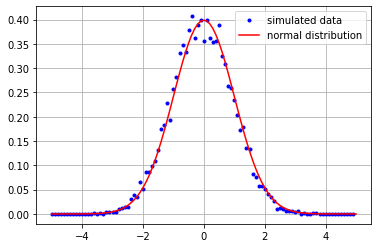

In [15]:
def X(n):
    return np.sum(np.cos(4*np.pi*(np.random.rand(n)-0.5)))/np.sqrt(n/2)

n= 10000
Xs = [X(n) for i in range(10000)]
y, x = np.histogram(Xs, 100, range=[-5,5])
plt.plot(x[:-1], y/1000, 'b.', label='simulated data')
plt.plot(x, norm.pdf(x), '-r', label='normal distribution')
plt.grid()
plt.legend()
plt.show()

Furthermore, $x$ and $y$ are uncorrelated since, in the expression for covariance of $x$ and $y$, the sums of products of cosine and sine terms cancel to zero. This means that  $x + {\bf i}y$, and hence the observed single look complex signal $S_{vv}$ (see Eq. (1.8)), has a _complex normal distribution_ .

Now what about the pixels values in the Sentinel-1 VV intensity images? They are given by the square of the amplitude of $S_{vv}$,

$$
|S_{vv}|^2 = S_{vv}S^*_{vv} = {|S^a_{vv}|^2\over n}(x^2+y^2). \tag{1.9}
$$

(Actually averages of the above, as we'll see later.) We can write this in the form

$$
|S_{vv}|^2 =  {|S^a_{vv}|^2\over n}{n\over 2}\left({x^2\over n/2}+{y^2\over n/2}\right) = |S^a_{vv}|^2{u\over 2}, \tag{1.10}
$$

where 

$$
u = \left({x^2\over n/2}+{y^2\over n/2}\right) \tag{1.11}
$$

is the sum of the squares of two variables with independent standard normal distributions. Applying the  

   - __Theorem:__ If the measurements $x_i,\ i=1\dots m$, are independent and standard normally distributed (i.e., with mean $0$ and variance $1$), then the variable $x=\sum_{i=1}^m x_i^2$ is  chi-square distributed with $m$ degrees of freedom, given by

$$
p_{\chi^2;m}(x)={1 \over 2^{m/2}\Gamma(m/2)} z^{(m-2)/2} e^{-x/2},\quad {\rm mean}(x)=m,\quad {\rm var}(x) = 2m. \tag{1.12}
$$

we see that $u$ is chi-square distributed with degrees of freedom $m=2$,

$$
p_u(u) = {1\over 2}e^{-u/2} \tag{1.13}
$$

since $\Gamma(1)=1$.

To simplify the notation, let $s=|S_{vv}|^2 $ and  $a=|S^a_{vv}|^2$. Then from (1.10)

$$
s = a{u\over 2} \tag{1.14}
$$

To get the distribution $p_s(s)$ of the observed signal from the distribution of $u$, we apply the standard transformation formula

$$
p_s(s) = p_u(u)\left|{du\over ds}\right| = {1\over 2}e^{-u/2}{2\over a} = {1\over a} e^{-s/a}. \tag{1.15}
$$

Compare this with the definition of the _exponential probability distribution_

$$
p_{e;\beta}(x) = {1\over\beta}e^{-x/\beta},\quad {\rm mean}(x) = \beta,\quad {\rm var}(x) = \beta. \tag{1.16}
$$

We conclude that the measured intensity signal $s=|S_{vv}|^2$ has an exponential distribution with mean and variance equal to the underlying signal strength $a=|S^a_{vv}|^2$.

So far so good, however we still haven't quite characterized the statistics of the pixels in the intensity bands of the Sentinel-1 images. 


### Multi-look SAR statistics

Multi-look processing essentially corresponds to the averaging of neighborhood pixels with the objective
of reducing speckle and compressing the data. In practice, the averaging is often not performed in the
spatial domain, but rather in the frequency domain during range/azimuth compression of the received signal. 

Look averaging takes place at the cost of spatial resolution. The spatial resolution attainable with SAR satellite platforms  involves, among many other considerations, a compromise between azimuthal resolution and swath width, see  [Moreira et al. (2013)](https://elib.dlr.de/82313/) for a good discussion. In the Sentinel-1 _Interferometric Wide Swath_ acquisition mode, the pixels are about 20m $\times$ 4m (azimuth $\times$ range) in extent and the swath widths are about 250km. For the multi-looking procedure, five cells are incoherently averaged in the range direction to achieve approx. $20m \times 20m$ resolution. The pixels are then resampled to $10\times 10\ m^2$. (Note that spatial resolution is a measure of the system's ability to distinguish between adjacent targets while pixel spacing is the distance between adjacent pixels in an image, measured in metres.) The look averaging process, which we can symbolize using angular brackets as $\langle |S_{vv}|^2 \rangle$ or $\langle |S_{vh}|^2 \rangle$, has the desirable effect of reducing speckle (at the cost of resolution) in the intensity images. We can see this as follows, first quoting another well-known Theorem in statistics:

   - __Theorem:__ If the quantities $s_i,\ i=1\dots m,$ are independent and each have exponential distributions given by Eq. (1.16), then $x = \sum_{i=1}^m s_i$ has the gamma distribution Eq. (1.1) with $\alpha=m,\ \beta=a$. Its mean is $\alpha\beta =ma$ and its variance is $\alpha\beta^2 = ma^2.$

Again with the notation $s=|S_{vv}|^2 $ and  $a=|S^a_{vv}|^2$, if intensity measurements $s$ are summed over $m$ looks to give $\sum_{i=1}^m s_i$, then according to this Theorem  the sum (not the average!) will be gamma distributed with $\alpha= m$ and $\beta=a$, provided the $s_i$ are independent. The look-averaged image is

$$
\langle s\rangle = {1\over m}\sum_{i=1}^m s_i \tag{1.17}
$$

and its mean value is

$$
{\rm mean}(\langle s\rangle) = {1\over m}\sum_{i=1}^m {\rm mean}(s_i) = {1\over m}\sum_{i=1}^m a = a. \tag{1.18}
$$

Now we see that the histogram of the Sentinel-1 multi-look image $\langle s\rangle =\langle |S_{vv}|^2 \rangle$ follows a gamma distribution with the parameters 

$$
\alpha=m,\quad \beta' = {a\over m} = {{\rm mean}(\langle s\rangle)\over m}, \tag{1.19}
$$

as we demonstrated earlier with the measured histogram.

The covariance representation of the dual pol multilook images is 

$$
C2 = \pmatrix{\langle|S_{vv}|^2\rangle & 0 \cr 0 & \langle|S_{vh}|^2\rangle}. \tag{1.20}
$$


### Equivalent number of looks

The variance of $\langle s\rangle$ is given by

$$
{\rm var}(\langle s\rangle) = {1\over m^2}{\rm var}(\sum_{i=1}^m s_i)= {1\over m^2}ma^2 = {a^2\over m}, \tag{1.21}
$$

where we have used the fact that the variance of the gamma distribution is $\alpha\beta'^2=ma^2$. Thus the variance of the look-averaged image, the speckle effect, decreases inversely with the number of looks.


In practice, the neighborhood pixel intensities contributing to the look average will not be completely independent, but correlated to some extent. This is accounted for by defining an _equivalent number of looks_
(ENL) whose definition is motivated by Eq. (1.21), that is,

$$
{\rm ENL} = {a^2\over {\rm var}(\langle s\rangle)} = {{\rm mean}(\langle s\rangle)^2\over {\rm var}(\langle s\rangle)}.\tag{1.22}
$$

In general it will be smaller than $m$. Let's see what we get for our subset of the airport image:

In [16]:
mean ** 2 / variance

0.020391786838855935

The value given by the provider (ESA) for the IW mode imagery in the GEE archive is ENL = 4.4, an average over all swaths, so our spatial subset seems to be fairly representative.

### Outlook

Now we have a good idea of the statistics of the Sentinel-1 images on the GEE. In [Part 2](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2) of the Tutorial we will discuss statistical methods to detect changes in two Sentinel-1 images acquired at different times.